# 1. Introduction

To start, we'll focus on the **holdout validation technique**, which involves:

* splitting the full dataset into 2 partitions:
  * a training set
  * a test set
* training the model on the training set,
* using the trained model to predict labels on the test set,
* computing an error metric to understand the model's effectiveness,
* switch the training and test sets and repeat,
* average the errors.

* ` In holdout validation, we usually use a 50/50 split instead of the 75/25 split from train/test validation. This way, we remove the number of observations as a potential source of variation in our model performance`.

## TODO:
* Use the numpy.random.permutation() function to shuffle the ordering of the rows in dc_listings.
* Select the first 1862 rows and assign to split_one.
* Select the remaining 1861 rows and assign to split_two.

In [1]:
import pandas as pd
import numpy as np

dc_listings=pd.read_csv('dc_airbnb.csv')
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
dc_listingss=dc_listings.copy()

In [2]:
shuffled_index = np.random.permutation(dc_listings.index)
dc_listings = dc_listings.reindex(shuffled_index)

In [3]:
split_one=dc_listings.iloc[0:1862].copy()
split_two=dc_listings.iloc[1862:].copy()

# 2. Holdout Validation

## TODO:
* Train a k-nearest neighbors model using the default algorithm (auto) and the default number of neighbors (5) that:
  * Uses the accommodates column from train_one for training and
  * Tests it on test_one.
* Assign the resulting RMSE value to iteration_one_rmse.
* Train a k-nearest neighbors model using the default algorithm (auto) and the default number of neighbors (5) that:
* Uses the accommodates column from train_two for training and
  * Tests it on test_two.
  * Assign the resulting RMSE value to iteration_two_rmse.
* Use numpy.mean() to calculate the average of the 2 RMSE values and assign to avg_rmse.

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

train_one=split_one
test_one=split_two
train_two=split_two
test_two=split_one

knn=KNeighborsRegressor()
knn.fit(train_one[['accommodates']],train_one['price'])
predictions_1=knn.predict(test_one[['accommodates']])
iteration_one_rmse=mean_squared_error(test_one['price'],predictions_1)**1/2


knn=KNeighborsRegressor()
knn.fit(train_two[['accommodates']],train_two['price'])
predictions_2=knn.predict(test_two[['accommodates']])
iteration_two_rmse=mean_squared_error(test_two['price'],predictions_2)**1/2

avg_rmse=np.mean([iteration_one_rmse,iteration_two_rmse])

# 3. K-Fold Cross Validation

 Holdout validation is actually a specific example of a larger class of validation techniques called k-fold cross-validation. `While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data,` both models that are trained only use half the available data. **K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.**

`Holdout validation is essentially a version of k-fold cross validation when k is equal to 2`. Generally, 5 or 10 folds is used for k-fold cross-validation. Here's a diagram describing each iteration of 5-fold cross validation:


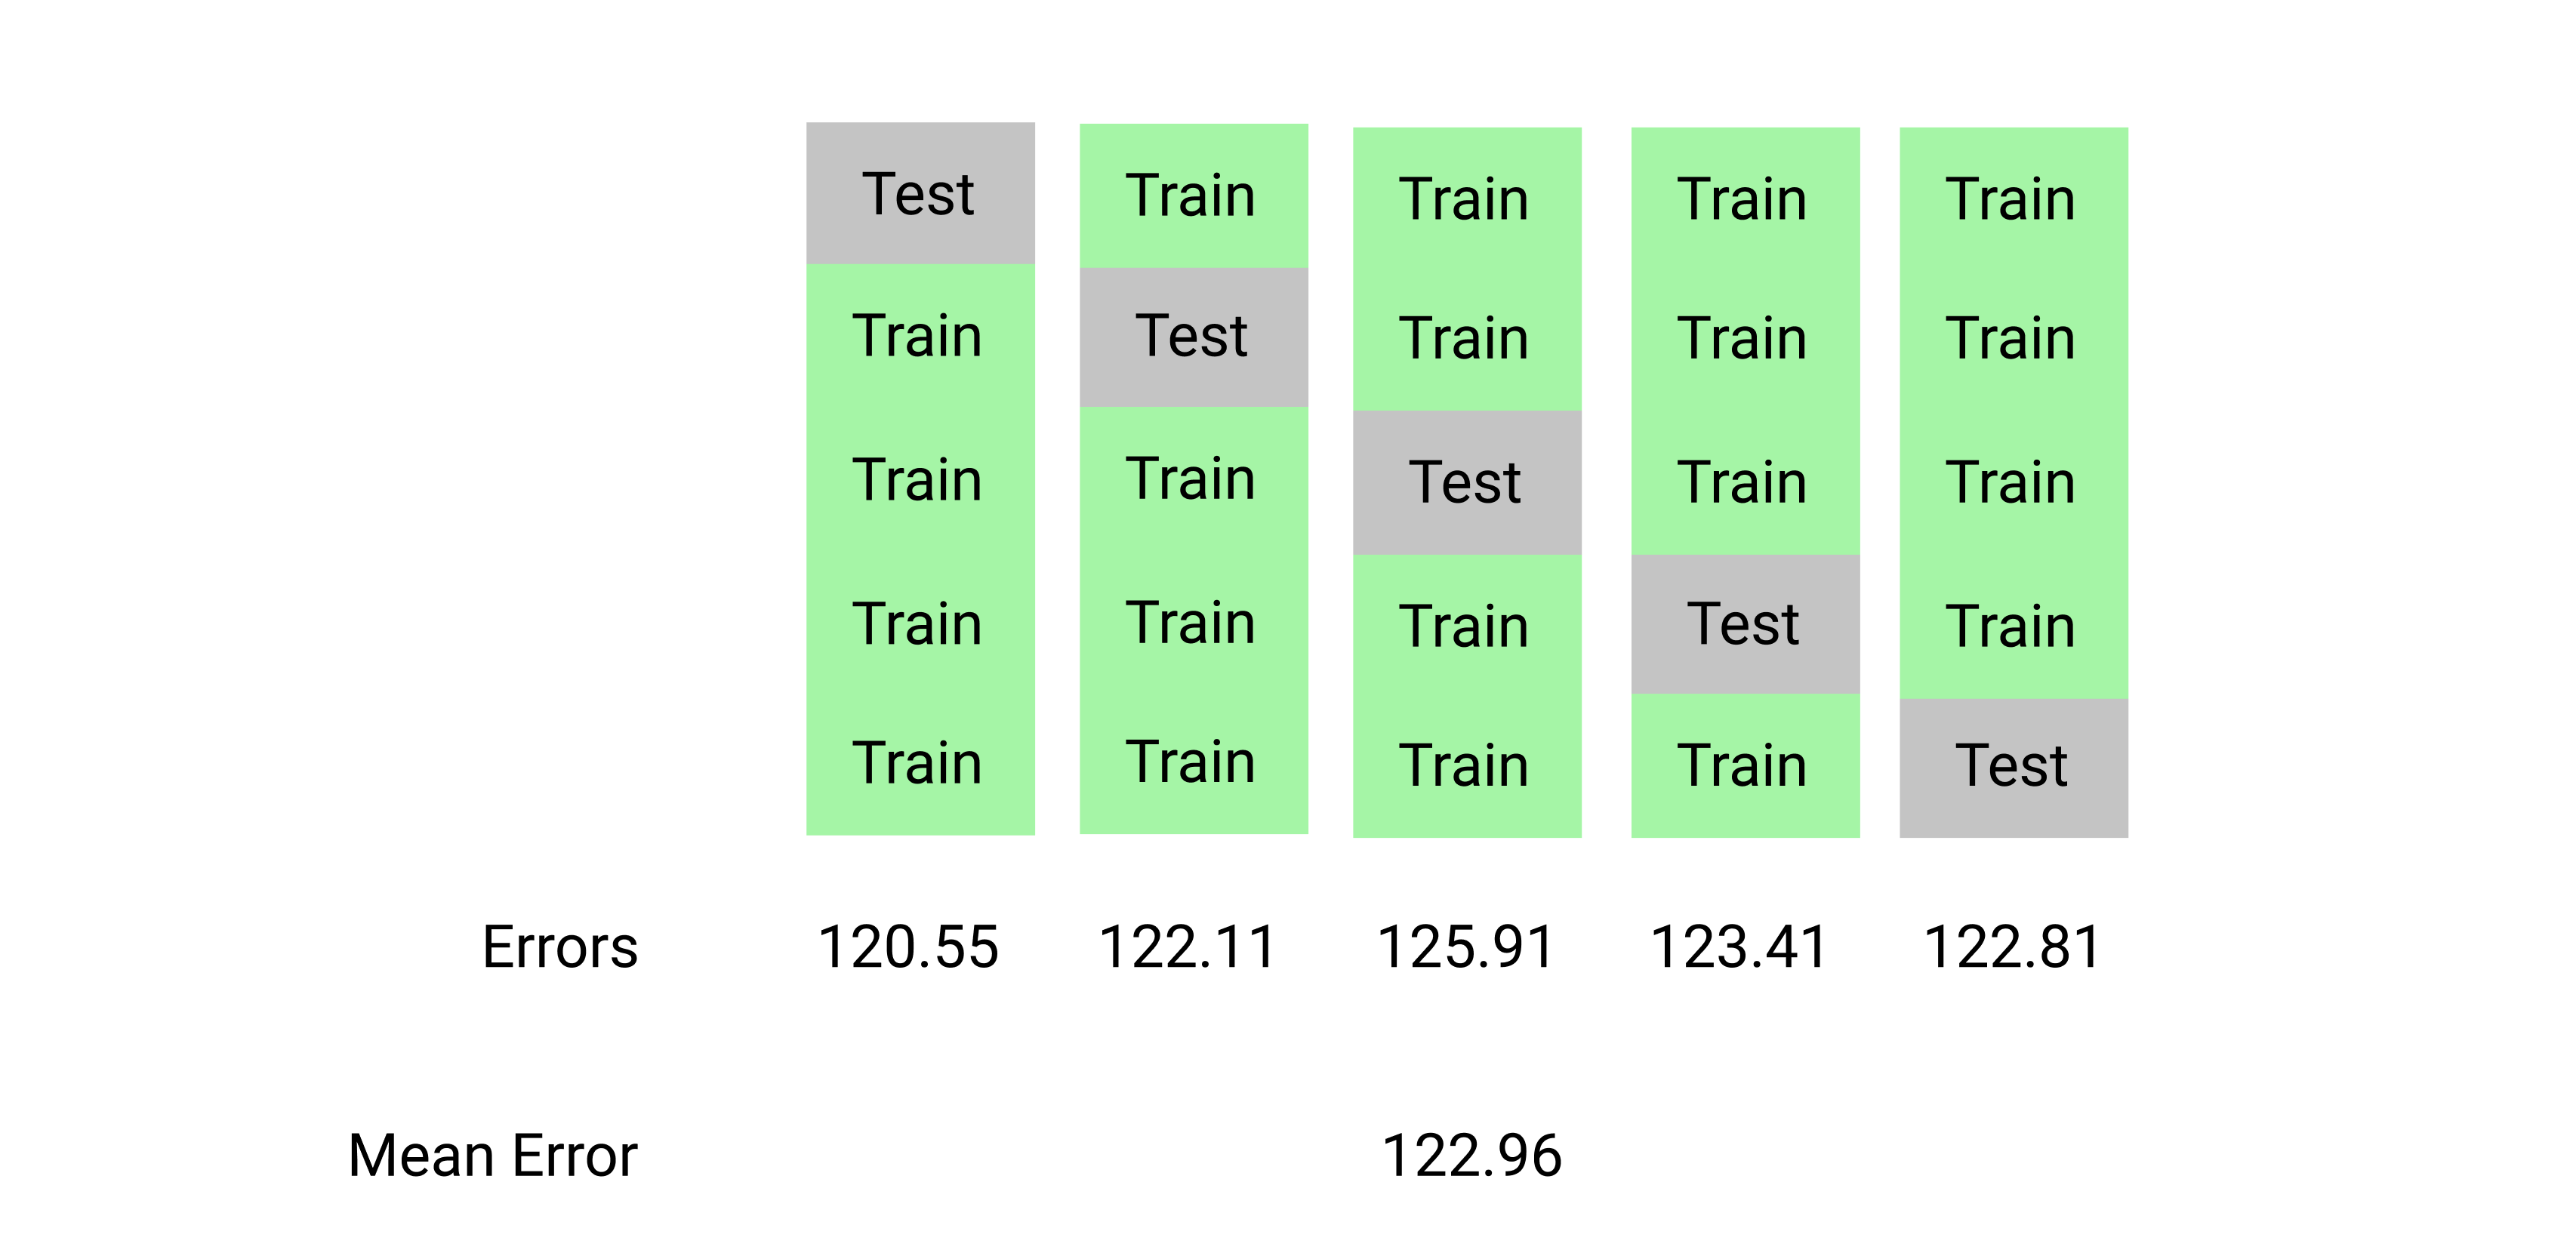

In [5]:
from IPython.display import Image
Image(filename='kfold_cross_validation.png')

## TODO:
* Add a new column to dc_listings named fold that contains the fold number each row belongs to:
  * Fold 1 should have rows from index 0 up to745, not including 745.
  * Fold 2 should have rows from index 745 up to 1490, not including 1490.
  * Fold 3 should have rows from index 1490 up to 2234, not including 2234.
  * Fold 4 should have rows from index 2234 up to 2978, not including 2978.
  * Fold 5 should have rows from index 2978 up to 3723, not including 3723.
* Display the unique value counts for the fold column to confirm that each fold has roughly the same number of elements.
* Display the number of missing values in the fold column to confirm we didn't miss any rows.

In [6]:
# I used original cleaned dataframe as above dataframe is shuffled and creating issue in analysing due to shuffled indices

dc_listingss.loc[0:745,'fold']=1
dc_listingss.loc[745:1490,'fold']=2
dc_listingss.loc[1490:2234,'fold']=3
dc_listingss.loc[2234:2978,'fold']=4
dc_listingss.loc[2978:3722,'fold']=5

In [7]:
dc_listingss['fold'].value_counts()

5.0    745
2.0    745
1.0    745
4.0    744
3.0    744
Name: fold, dtype: int64

In [8]:
dc_listingss['fold'].isnull().sum()

0

In [9]:
# This way dataframe.index[] we can directly work on shuffled dataframe

dc_listings.loc[dc_listings.index[0:745], "fold"] = 1
dc_listings.loc[dc_listings.index[745:1490], "fold"] = 2
dc_listings.loc[dc_listings.index[1490:2234], "fold"] = 3
dc_listings.loc[dc_listings.index[2234:2978], "fold"] = 4
dc_listings.loc[dc_listings.index[2978:3723], "fold"] = 5

print(dc_listings['fold'].value_counts())
print("\n Num of missing values: ", dc_listings['fold'].isnull().sum())

5.0    745
2.0    745
1.0    745
4.0    744
3.0    744
Name: fold, dtype: int64

 Num of missing values:  0


# 4. First iteration

## TODO:
* Train a k-nearest neighbors model using the accommodates column as the sole feature from folds 2 to 5 as the training set.
* Use the model to make predictions on the test set (accommodates column from fold 1) and assign the predicted labels to labels.
* Calculate the RMSE value by comparing the price column with the predicted labels.
* Assign the RMSE value to iteration_one_rmse.

In [10]:
# Training
model = KNeighborsRegressor()
train_iteration_one = dc_listings[dc_listings["fold"] != 1]
test_iteration_one = dc_listings[dc_listings["fold"] == 1].copy()
model.fit(train_iteration_one[["accommodates"]], train_iteration_one["price"])

# Predicting
labels = model.predict(test_iteration_one[["accommodates"]])
test_iteration_one["predicted_price"] = labels
iteration_one_mse = mean_squared_error(test_iteration_one["price"], test_iteration_one["predicted_price"])
iteration_one_rmse = iteration_one_mse ** (1/2)

# 5. Function for training models

From the first iteration, we achieved an RMSE value of roughly 124. Let's calculate the RMSE values for the remaining iterations. To make the iteration process easier, let's wrap the code we wrote in the previous screen in a function.

## TODO:
* Write a function named train_and_validate that takes in a dataframe as the first parameter (df) and a list of fold values (1 to 5 in our case) as the second parameter (folds). This function should:

  * Train n models (where n is number of folds) and perform k-fold cross validation (using n folds). Use the default k value for the KNeighborsRegressor class.
  * Return a list of RMSE values, where the first element is the RMSE for when fold 1 was the test set, the second element is the RMSE for when fold 2 was the test set, and so on.
* Use the train_and_validate function to return the list of RMSE values for the dc_listings Dataframe and assign to rmses.

* Calculate the mean of these values and assign to avg_rmse.
* Display both rmses and avg_rmse.

In [11]:
fold_ids = [1,2,3,4,5]

def train_and_validate(df, folds):
    fold_rmses = []
    for fold in folds:
        
        # Train
        model = KNeighborsRegressor()
        train = df[df["fold"] != fold]
        test = df[df["fold"] == fold].copy()
        model.fit(train[["accommodates"]], train["price"])
        
        # Predict
        labels = model.predict(test[["accommodates"]])
        test["predicted_price"] = labels
        mse = mean_squared_error(test["price"], test["predicted_price"])
        rmse = mse**(1/2)
        fold_rmses.append(rmse)
    return(fold_rmses)

rmses = train_and_validate(dc_listings, fold_ids)
print(rmses)
avg_rmse = np.mean(rmses)
print(avg_rmse) 

[113.57879303896445, 171.55818939646483, 117.18301557727958, 92.43488437523122, 144.02582840699841]
127.7561421589877


# 6. Performing K-Fold Cross Validation Using Scikit-Learn

## TODO:
* Create a new instance of the KFold class with the following properties:

  * 5 folds,
  * shuffle set to True,
  * random seed set to 1 (so we can answer check using the same seed),
  * assigned to the variable kf.
  * Create a new instance of the KNeighborsRegressor class and assign to knn.

* Use the cross_val_score() function to perform k-fold cross-validation:

  * using the KNeighborsRegressor instance knn,
  * using the accommodates column for training,
  * using the price column as the target column,
  * returning an array of MSE values (one value for each fold).
* Assign the resulting list of MSE values to mses. Then, take the absolute value followed by the square root of each MSE value. * Then, calculate the average of the resulting RMSE values and assign to avg_rmse.

In [14]:
from sklearn.model_selection import cross_val_score,KFold

In [16]:
kf=KFold(n_splits=5,shuffle=True,random_state=1)
knn=KNeighborsRegressor()

In [17]:
mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)

print(rmses)
print(avg_rmse)

[108.44825271 117.13772815 105.71631762 120.94757418 182.11518038]
126.8730106084057


# 7. Exploring Different K Values

Choosing the right k value when performing k-fold cross validation is more of an art and less of a science. As we discussed earlier in the mission, a k value of 2 is really just holdout validation. On the other end, `setting k equal to n (the number of observations in the data set)` is known as **leave-one-out cross validation, or LOOCV for short**

In [18]:
num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  124.92244069257156 std RMSE:  27.586322942828556
5 folds:  avg RMSE:  126.8730106084057 std RMSE:  28.17325399742295
7 folds:  avg RMSE:  128.90362263849576 std RMSE:  25.64258927452343
9 folds:  avg RMSE:  128.8317458182738 std RMSE:  29.051805155751566
10 folds:  avg RMSE:  126.74761660102176 std RMSE:  29.033810803504576
11 folds:  avg RMSE:  128.34038978610445 std RMSE:  30.463008782589753
13 folds:  avg RMSE:  128.74653348892096 std RMSE:  35.78938933227636
15 folds:  avg RMSE:  125.28910112714503 std RMSE:  37.177826592942765
17 folds:  avg RMSE:  124.40619641263201 std RMSE:  34.74303517118308
19 folds:  avg RMSE:  123.08145681860192 std RMSE:  37.64288017660316
21 folds:  avg RMSE:  126.613210014248 std RMSE:  39.24330088325705
23 folds:  avg RMSE:  125.84084859310742 std RMSE:  39.91928869818523


# 8. Bias-Variance Tradeoff

So far, we've been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. **A model has two sources of error, bias and variance.**

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's variance while the average RMSE is a proxy for a model's bias. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.

While k-nearest neighbors can make predictions, it isn't a mathematical model. A mathematical model is usually an equation that can exist without the original data, which isn't true with k-nearest neighbors.